# More advanced example
We next choose to fit a dataset which is inherently two dimensional, so we will require triangles.  The exact EM algorithm only applies for 1-dimensional simplices, so we will need to use a Markov chain Monte Carlo version.

## Imports

In [1]:
import numpy as np
from smm.lemm import SimplicialMM, GLEMM_Parameters, MCMC_Integrator
from smm.helpfulfunctions import initialise_V

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Generate and plot data
We generate data on a Mobius strip

<IPython.core.display.Javascript object>


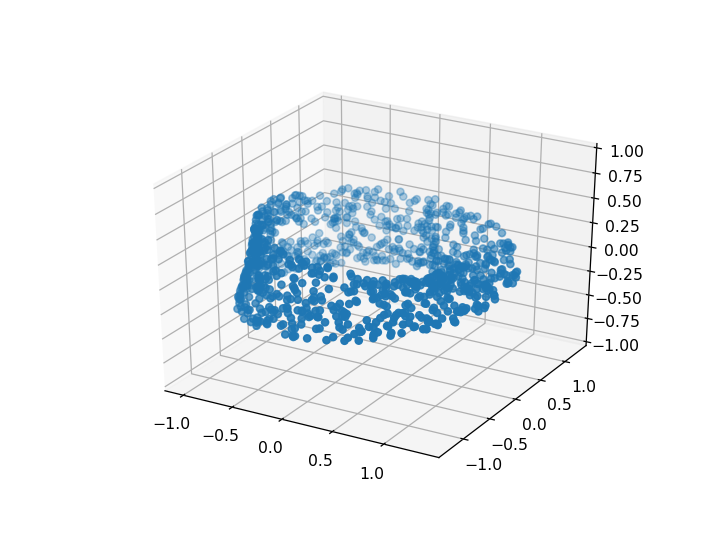

In [2]:
def Mobius_strip(n_points, width, rnd):
    θ = 2 * np.pi * rnd.rand(n_points)
    u = width * (rnd.rand(n_points)-0.5)
    
    X = np.vstack([np.cos(θ), np.sin(θ), np.zeros_like(θ)]).T
    N = X * np.cos(θ / 2)[:,None] + np.array([[0.0,0.0,1.0]]) * np.sin(θ / 2)[:,None]
    
    return X + u[:,None] * N

X = Mobius_strip(1000, 0.75, np.random.RandomState(123))
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(xs=X[:,0], ys=X[:,1], zs=X[:,2])
ax.set_zlim(-1.0, 1.0)
plt.show()

## Defining the model
We choose to use a model with two-dimensional simplices.

The model and initial parameters are setup as usual.  However we also define a class which holds the Markov chains used to perform estimation in the expectation (E) step of the EM algorithm.

In [3]:
m = 20
k = 2
n = 3
L = SimplicialMM(m, n, k, support_dims=[2])
L.rnd.seed(123)

print(f"Using {L.M} simplices.")

θ = GLEMM_Parameters(
        X[L.rnd.choice(range(X.shape[0]), m, replace=False)],
        L.M, covar_type='spherical', covar=0.1)

# Taking 10 copies of the data has the effect
# of running 10 Markov chains in parallel
Xtrain = np.vstack([X]*10)

M = MCMC_Integrator(L, θ, Xtrain, rnd=L.rnd)

Using 1140 simplices.


## Fitting the model
We must define a 'regime' for the Markov chains to follow, the most important step being the maximisation `m` step.
The types of step are

* `C` - jump to a different simplex
* `U` - walk within current simplex
* `q` - contribute to the estimated expected "q-values"
* `m` - perform a maximisation step using the current estimates.

Typically the more steps, `C` and `U` and contributions `q` per maximisation the better the result.

In [4]:
regime = "CUUUq"*20 + "m"
for i in range(500):
    M.perform(regime)
    if (i+1)%50 == 0:
#         print(M.L.estimated_log_likelihood(M.TH, X))
        print(f"Intrinsic encoding rate: {M.L.encoding_rate(M.TH):.3f}")

Intrinsic encoding rate: -0.682
Intrinsic encoding rate: -1.352
Intrinsic encoding rate: -1.674
Intrinsic encoding rate: -1.854
Intrinsic encoding rate: -1.990
Intrinsic encoding rate: -2.093
Intrinsic encoding rate: -2.183
Intrinsic encoding rate: -2.244
Intrinsic encoding rate: -2.281
Intrinsic encoding rate: -2.326


<IPython.core.display.Javascript object>


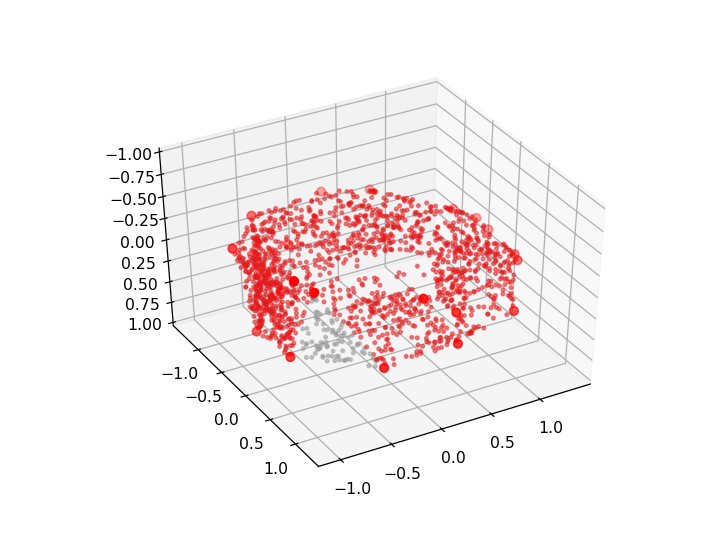

In [5]:
Y, Ylabels = L.sample(M.TH, 1600)
cols = np.zeros(Y.shape[0])
cols[Ylabels == L.top_components(M.TH)[0][0]] = 1
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(xs=Y[:,0], ys=Y[:,1], zs=Y[:,2], c=cols, cmap="Set1", alpha=0.5, s=5)
ax.scatter(xs=M.TH.V[:,0], ys=M.TH.V[:,1], zs=M.TH.V[:,2], c='r', s=30)
ax.set_zlim(-1.0, 1.0)
plt.show()